In [1]:
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.compare import *
from pymodulon.io import load_json_model
from pymodulon.plotting import *
from pymodulon.example_data import load_bsub_data, load_ecoli_data
from sklearn.metrics.pairwise import cosine_similarity

# Comparison of iModulons across species
Try to make some sort of network analysis comparing iMs across multiple species.

1. Define a new function `compare_ica_multi` that takes in a list of M matrices and a list of orthology files. The list of M matrices should be a list of tuples, where each tuple contains the M matrix and the name of the organism. The list of orthology files should be a list of tuples, where each tuple contains the path to the orthology file and the names of the two organisms it maps between.

2. In the `compare_ica_multi` function, loop over the list of M matrices. For each M matrix, convert the gene index to be consistent with the gene index of the first M matrix in the list. Use the `convert_gene_index` function for this, and use the appropriate orthology file based on the names of the organisms.

3. After converting the gene index of all M matrices, loop over all pairs of M matrices. For each pair, find the orthologous iModulons using the `_get_orthologous_imodulons` function. Store the matches in a list.

4. If the `plot` flag is set to True, generate a dot graph for each pair of M matrices using the `_make_dot_graph` function. Store the dot graphs in a list.

5. Return the list of matches and the list of dot graphs.

# Load all ICA objects to allow for comparison

In [2]:
data_dir = path.join('../../','data','external', 'modulome', 'ica_objects')

ecol_ica = load_json_model(data_dir + '/precise1k.json')
mtub_ica = load_json_model(data_dir + '/mtb_ica.json')
pae_ica = load_json_model(data_dir + '/paeru_116_iModulon.json')
sen_ica = load_json_model(data_dir + '/core.json')
sac_ica = load_json_model(data_dir + '/saci_ica_data.json')
salb_ica = load_json_model("../../data/processed/modulome/salb.json.gz")
bsub_ica = load_json_model(data_dir + '/bsu.json.gz')

# Get the M files
ecol_m = ecol_ica.M
mtub_m = mtub_ica.M
pae_m = pae_ica.M
sen_m = sen_ica.M
sac_m = sac_ica.M
salb_m = salb_ica.M
bsub_m = bsub_ica.M

# Load the orthogroup mapping
orthogroup_mapping = pd.read_csv('../../data/external/modulome/orthogroup_mapping.tsv', index_col=0, sep='\t')

# Load the merged M file
M = pd.read_csv('../../data/processed/modulome/merged_M_max_gene_names.csv', index_col=0)

edges = pd.read_csv('../../data/processed/modulome/network2.csv')

# Load the cluster info file, generated from cytoscape
clusters = pd.read_csv('../../data/processed/modulome/network_table.csv')

# Panel 2: Compare iModulons across species


## Phosphate

### Heatmap

Putative core genes in cluster 24: 6 (['wcaA', 'pstS', 'pstB', 'pstA', 'pstC', 'yddL'])


<Figure size 393.701x610.236 with 0 Axes>

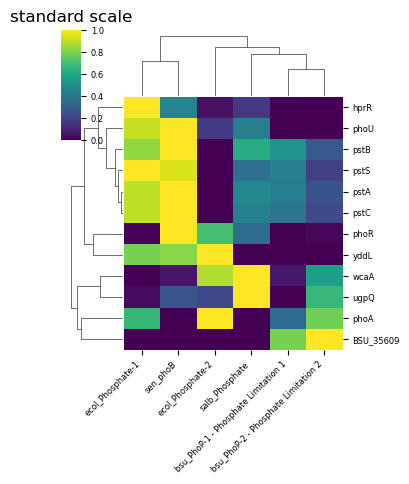

In [10]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 24

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.5)

# Set gene weight threshold
threshold = 0.1

# Take the absolute value of the weights
abs_weights = weights.abs()

# Filter if at least 2 iModulon have a weight (absolute value) above the threshold
filtered_weights = abs_weights[(abs_weights > threshold).sum(axis=1) >= 2]

# Count the number of iModulons where each gene's weight (absolute value) is above the threshold
counts = (abs_weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 100 / 25.4  # ~6.69 inches
height = 155 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height), standard_scale=0)  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('/Users/nilmat/Documents/streptsd/reports/figures/modulome/Fig2/hm_phosphate.svg', format='svg', dpi=300)
plt.show()

In [7]:
# Get the average edge weights for the phosphate subcluster
phosphate_subcluster = clusters.loc[clusters['__mclCluster'] == 24]

# Get the list of iModulons
iModulons = phosphate_subcluster['name'].tolist()

# Extract the edge weights for the iModulons
edge_weights = edges[edges['Source'].isin(iModulons) & edges['Target'].isin(iModulons)]

# Get the average edge weight
average_edge_weight = edge_weights['Weight'].mean()

print(f'Average edge weight for phosphate subcluster: {average_edge_weight}')

Average edge weight for phosphate subcluster: 0.3633647712814872


## Translation

In [31]:
clusters.loc[clusters['name'] == 'salb_Translation']

,__mclCluster,name,selected,shared name,species
91,13.0,salb_Translation,False,salb_Translation,Sal


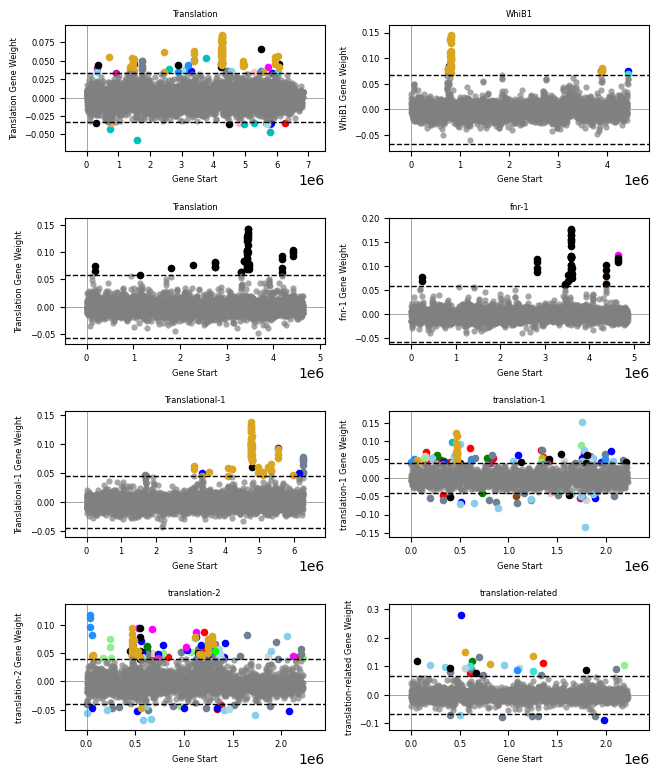

In [30]:
# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 170 / 25.4  # ~6.69 inches
height = 200 / 25.4  # ~7.87 inches

# Define a list of ICA objects and corresponding imodulons
ica_objects = [salb_ica, mtub_ica, ecol_ica, sen_ica, pae_ica, sac_ica, sac_ica, sac_ica]
imodulons = ['Translation', 'WhiB1', 'Translation', 'fnr-1', 'Translational-1', 'translation-1', 'translation-2', 'translation-related']

# Create a grid of subplots with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(width, height))

# Loop over the subplots and plot the gene weights
for i, ax in enumerate(axs.flat):
    if i < len(imodulons):
        # Use the corresponding ICA object for each imodulon
        plot_gene_weights(ica_objects[i], imodulons[i], show_labels=False, label_font_kwargs={'fontsize':6}, ax=ax, legend=False, scatter_kwargs={'s': 20})
        ax.set_title(imodulons[i], fontsize=6)

        # Increase x and y axis text size
        ax.tick_params(axis='both', which='major', labelsize=6)

        # Increase x and y axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=6)
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
#plt.savefig(path.join(figure_dir,'panel3.svg'), dpi=300)
plt.show()

Putative core genes in cluster 13: 22 (['rpsR', 'rpsJ', 'rplC', 'rplW', 'rplB', 'rpsS', 'rpsC', 'rpmC', 'rplN', 'rplE', 'rpsH', 'rplF', 'rpsE', 'rplD', 'rplV', 'rplP', 'rpsQ', 'rplX', 'rplR', 'rpmD', 'rplO', 'rplI'])


<Figure size 393.701x570.866 with 0 Axes>

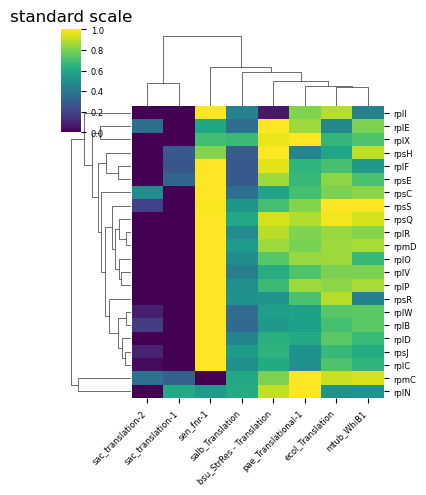

In [9]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 13

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.25)

# Set gene weight threshold
threshold = 0.1

# Filter if at least two iModulons have a weight above the threshold
filtered_weights = weights[(weights > threshold).sum(axis=1) >= 2]

# Count the number of iModulons where each gene's weight is above the threshold
counts = (weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 100 / 25.4  # ~6.69 inches
height = 145 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height), standard_scale=0)  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('/Users/nilmat/Documents/streptsd/reports/figures/modulome/Fig2/hm_translation.svg', format='svg', dpi=300)
plt.show()

In [9]:
# Get the average edge weights for the phosphate subcluster
subcluster = clusters.loc[clusters['__mclCluster'] == 13]

# Get the list of iModulons
iModulons = subcluster['name'].tolist()

# Extract the edge weights for the iModulons
edge_weights = edges[edges['Source'].isin(iModulons) & edges['Target'].isin(iModulons)]

# Get the average edge weight
average_edge_weight = edge_weights['Weight'].mean()

print(f'Average edge weight for translation subcluster: {average_edge_weight}')

Average edge weight for translation subcluster: 0.5294039804865671


# Panel 4: NRPS

In [40]:
clusters.loc[clusters['name'] == 'salb_Paulomycin-1']

,__mclCluster,name,selected,shared name,species
483,1.0,salb_Paulomycin-1,False,salb_Paulomycin-1,Sal


Putative core genes in cluster 1.0: 6 (['entA', 'ybdZ', 'entB', 'entF', 'entC', 'entE'])


<Figure size 590.551x472.441 with 0 Axes>

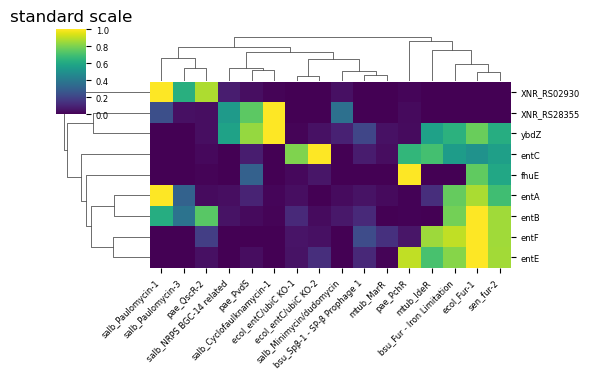

In [59]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 1.0

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Take the absolute value of the weights
weights = weights.abs()

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.25)

# Set gene weight threshold
threshold = 0.1

# Filter if at least two iModulons have a weight above the threshold
filtered_weights = weights[(weights > threshold).sum(axis=1) > 2]

# Count the number of iModulons where each gene's weight is above the threshold
counts = (weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 150 / 25.4  # ~6.69 inches
height = 120 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height), standard_scale=0)  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('/Users/nilmat/Documents/streptsd/reports/figures/modulome/Fig4/NRPS_cluster_heatmap_gene_names.svg', format='svg', dpi=300)
plt.show()

In [6]:
# Read the orthofinder results
orthogroups = pd.read_csv('../../data/external/modulome/orthofinder/Orthogroups/Orthogroups.tsv', sep='\t')

# Replace all NaN with 0 and all other cells with 1 in all columns except 'Orthogroup'
orthogroups.loc[:, orthogroups.columns != 'Orthogroup'] = orthogroups.loc[:, orthogroups.columns != 'Orthogroup'].notna().astype(int)

orthogroups.to_csv('../../data/external/modulome/orthofinder/Orthogroups/Orthogroups_binary.tsv', sep='\t', index=False)

In [8]:
orthogroups_gene_count = pd.read_csv('../../data/external/modulome/orthofinder/Orthogroups/Orthogroups.GeneCount.tsv', sep='\t')

orthogroups_gene_count

,Orthogroup,bsu2,ecol2,mtub2,pae2,sac2,salb2,sen2,Total
0,OG0000000,16,9,18,20,9,23,6,101
1,OG0000001,0,0,87,0,0,0,0,87
2,OG0000002,2,0,2,1,0,56,0,61
3,OG0000003,0,0,60,0,0,0,0,60
4,OG0000004,11,2,4,5,12,17,3,54
...,...,...,...,...,...,...,...,...,...
5257,OG0005257,0,0,0,0,0,0,2,2
5258,OG0005258,0,0,0,0,0,0,2,2
5259,OG0005259,0,0,0,0,0,0,2,2
5260,OG0005260,0,0,0,0,0,0,2,2


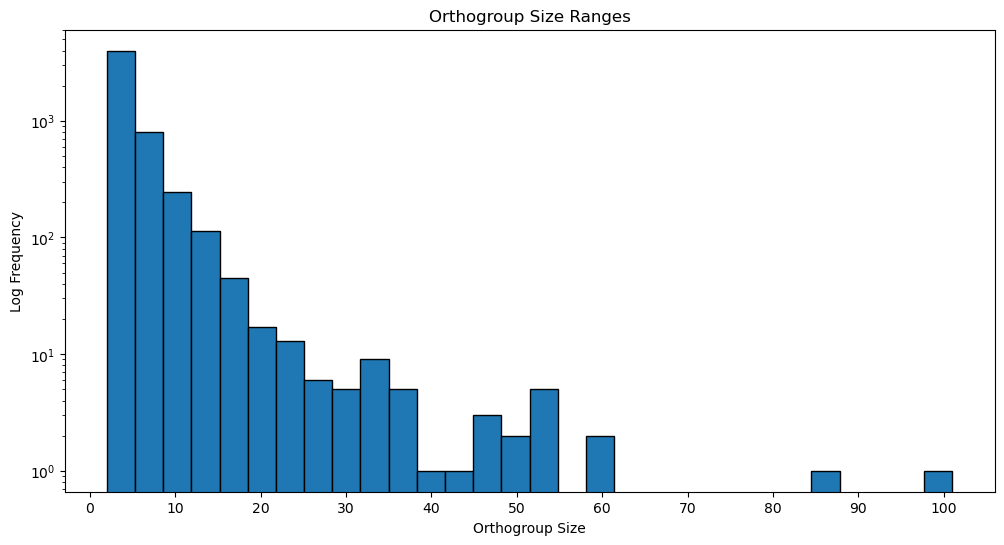

In [17]:
plt.figure(figsize=(12, 6))

# Create a histogram of the 'Total' column
plt.hist(orthogroups_gene_count['Total'], bins=30, edgecolor='black', log=True)

# Set the title and labels
plt.title('Orthogroup Size Ranges')
plt.xlabel('Orthogroup Size')
plt.ylabel('Log Frequency')

# Set x ticks
plt.xticks(np.arange(0, max(orthogroups_gene_count['Total'])+1, 10))

# Show the plot
plt.show()

In [18]:
# Get the frequencies of the orthogroup sizes
frequencies = orthogroups_gene_count['Total'].value_counts()

# Print the orthogroup sizes of the top 3 frequencies
print(frequencies.head(3))

2    1988
3    1096
4     559
Name: Total, dtype: int64
